In [1]:
# All of our important imports and some utility functions go here! :)
import skimage
import matplotlib.pyplot as plt # needed for plotting
# from matplotlib.colors import NoNorm
import matplotlib.colors as mcolors

import numpy as np # numpy is primary library for numeric array (and matrix) handling
from scipy import signal 
from skimage import feature
from skimage import filters
import os
import random
from skimage import io # for importing images

# Gaussian method from https://stackoverflow.com/a/46892763
# Where kernel length is the size of the kernel window
# and std is the sigma (standard deviation) of the gaussian window
def create_gaussian_kernel(kernlen=21, std=3):
    """Returns a 2D Gaussian kernel array."""
    gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
    gkern2d = np.outer(gkern1d, gkern1d)
    return gkern2d

# Utility method to plot an original image and a smoothed image
def plotFilteredImage(img, filteredImage, k, xZoom=(180, 410), yZoom=(230, 0)):
    imageHeight, imageWidth = img.shape
    f, axes = plt.subplots(2, 3, figsize=(15, 7)) # subplots is num rows, num cols & figsize is width, height

    # Recall that axes is row, col
    axes[0, 0].imshow(img, cmap='gray')
    axes[0, 0].set_title("The original image")

    axes[1, 0].imshow(img, cmap='gray')
    axes[1, 0].set_xlim(xZoom) # zoom in!
    axes[1, 0].set_ylim(yZoom) # zoom in!

    axes[0, 1].imshow(filteredImage, cmap='gray')
    axes[0, 1].set_title("The filtered image with k={}".format(k))

    axes[1, 1].imshow(filteredImage, cmap='gray')
    axes[1, 1].set_xlim(xZoom)
    axes[1, 1].set_ylim(yZoom)

    # Plot a few random rows to further highlight impact of smoothing operation
    for n in range(0, 2):
        randomRow = random.randint(k, imageHeight - k)
        axes[0, 2].plot(img[randomRow,], alpha=0.75, label="Row={} (raw)".format(randomRow))
        axes[0, 2].plot(filteredImage[randomRow,], alpha=0.75, label="Row={} (filtered)".format(randomRow))   

        randomRow = random.randint(yZoom[1], yZoom[0])
        axes[1, 2].plot(img[randomRow, ], alpha=0.75, label="Row={} (raw)".format(randomRow))
        axes[1, 2].plot(filteredImage[randomRow, ], alpha=0.75, label="Row={} (filtered)".format(randomRow))   

    axes[0, 2].legend()
    axes[0, 2].set_title("Sample rows from raw & filtered image")
    axes[1, 2].legend()
    axes[1, 2].set_xlim(xZoom)


# Play around with sci-kit image to build some familiarity

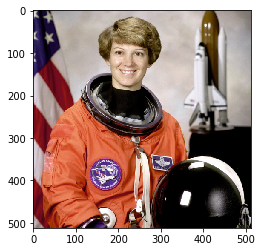

In [2]:
# The skiimage.data submodule provides a set of example images
# that can be used to get started quickly on exploring sckit-image
# See: http://scikit-image.org/docs/dev/api/skimage.data.html#module-skimage.data
from skimage import data
camera = data.astronaut()
plt.imshow(camera)

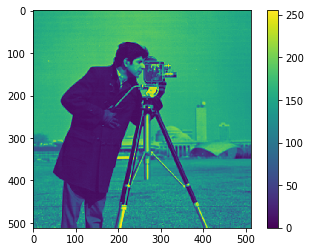

In [3]:
# Here's another example image that ships with scikit image
# This image is black and white; however, the default color map in matplotlib is greenish
# to plot this image in gray, add in cmap='gray' to the imshow function call
plt.imshow(data.camera())
plt.colorbar() # provides a color scale reference, see https://matplotlib.org/users/image_tutorial.html#color-scale-reference

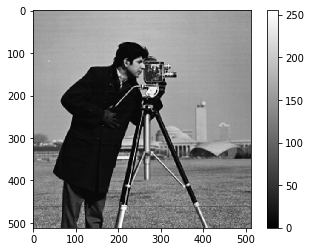

In [4]:
# Same image but now in grayscale (here, the intensity values are mapped to the more common white to black range)
plt.imshow(data.camera(), cmap='gray')
plt.colorbar()

(350, 50)

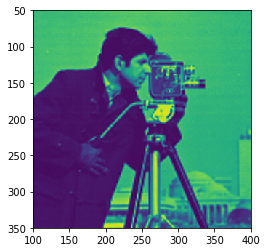

In [5]:
# Here's how you zoom into an image
plt.imshow(data.camera())
plt.xlim(100, 400)
plt.ylim(350, 50) # note that the y-axis is flipped

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 255   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 255 255   0   0   0   0   0   0]
 [  0   0 255 255 255 255 255 255 255 255 255   0   0   0   0   0]
 [  0   0 255 255 255 255 255 255 255 255 255 255 255   0   0   0]
 [  0   0 255 255 255 255 255 255 255 255 255 255 255 255   0   0]
 [  0   0 255 255 255 255 255 255 255 255 255 255 255   0   0   0]
 [  0   0 255 255 255 255 255 255 255 255 255 255   0   0   0   0]
 [  0   0   0   0   0   0   0   0 255 255   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 255   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 

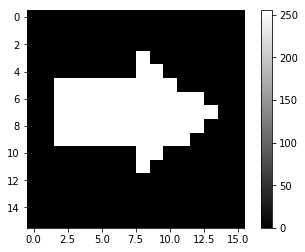

In [6]:
# Images are just numpy arrays! Check this out...
arrowNoAntiAliasing = io.imread("./Images/Arrow_16x16_NoAntiAliasing.png", as_grey=True)
print(arrowNoAntiAliasing)
plt.imshow(arrowNoAntiAliasing, cmap='gray')
plt.colorbar() 

# This means we can perform all sorts of really interesting image processing
# using all of the functionality of scipy (sometimes scikit-image wraps scipy 
# methods to make them easier to use in images. scikit-image also adds new functionality as well)

[[  0   0   0   0   0   0  18  30  34  30  18   0   0   0   0   0   0]
 [  0   0   0   0  29 111 201 246 255 246 201 111  29   0   0   0   0]
 [  0   0   0  67 215 255 255 255 255 255 255 255 215  67   0   0   0]
 [  0   0  62 246 255 255 255 255 255 255 255 255 255 246  63   0   0]
 [  0  20 225 255 255 255 255 255 255 255 255 255 255 255 226  22   0]
 [  0 113 255 255 255 255 255 255 255 255 255 255 255 255 255 115   0]
 [ 15 197 255 255 255 255 255 255 255 255 255 255 255 255 255 196  15]
 [ 28 240 255 255 255 255 255 255 255 255 255 255 255 255 255 241  29]
 [ 33 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255  33]
 [ 29 241 255 255 255 255 255 255 255 255 255 255 255 255 255 242  29]
 [ 15 197 255 255 255 255 255 255 255 255 255 255 255 255 255 197  15]
 [  0 113 255 255 255 255 255 255 255 255 255 255 255 255 255 115   0]
 [  0  20 225 255 255 255 255 255 255 255 255 255 255 255 226  23   0]
 [  0   0  63 246 255 255 255 255 255 255 255 255 255 246  64   0   0]
 [  0 

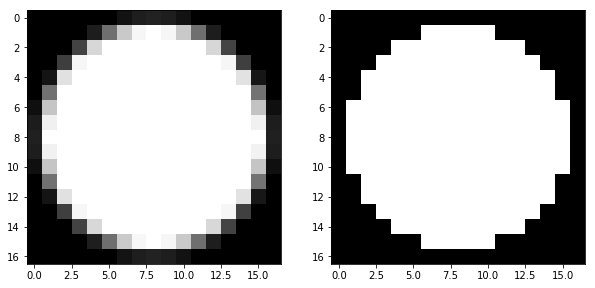

In [7]:
# Here's another example (two examples actually!)
# 1. One circle with anti-aliased edges (smooth edges)
# 2. One circle without anti-aliased edges (hard edges)
circleSmoothEdges = io.imread("./Images/Circle_17x17_AntiAliased.png")
circleHardEdges= io.imread("./Images/Circle_17x17_NoAntiAliasing.png")
print(circleSmoothEdges)
print(circleHardEdges)

f, axes = plt.subplots(1, 2, figsize=(10, 10)) # subplots is num rows, num cols & figsize is width, height

axes[0].imshow(circleSmoothEdges, cmap='gray')
axes[1].imshow(circleHardEdges, cmap='gray')

[[ 37  89  58  18  21  14   9  14  26  26  21  14   4  27 158]
 [101 121  25  15  10   3  17  48  46  27  31  27   3  17 207]
 [ 45  30   0   0  12  22  44  70  41  46  58  39   9  11 159]
 [ 39  13  43  48  31  62  85  54  31  30  17  39  18   0 113]
 [ 49  36 110  87  23  51  91  50  24  30  36  49  26   1  86]
 [ 59  31 117 111  69  65  99  74  32  34  47  62  44   0 107]
 [ 55  17 108 134 107  99 110  92  47  38  50  60  54  27 156]
 [135  49  91 135 110  97 102  92  56  42  47  57  45  85 185]
 [238 167  92 121  99  93  79  61  36  22  38  51  39  58 178]
 [238 198  70 115  87  80  79  52  38  30  27  36  46 153 209]
 [237 241 143 100  86  48  68 105  67  28  31  49  28  68 162]
 [237 255 163  64 103  51  19  42  24   6  43  53   5   0  50]
 [237 219  39  17  89 119  63  24  20  26  52  43   6  12  37]
 [171  71   7  40  95 108 110  62  40  44  42  27  19  26  34]
 [ 78   1  25  50  62  77  93  74  52  45  21  20  67  35  23]]


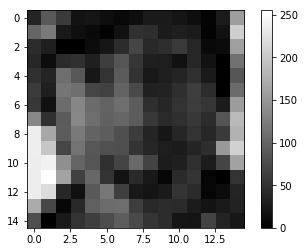

In [8]:
# my head as 15 pixels! :)
jonHead = io.imread("./Images/JonsHead15x15_bw.png", as_grey=True)
print(jonHead)
plt.imshow(jonHead, cmap='gray')
plt.colorbar() 

[[  0   0   0   0   7  15  20  21  19  14   7   0   0   0   0]
 [  0   0   3  16  29  41  49  52  49  41  29  16   3   0   0]
 [  0   3  19  39  57  73  85  88  84  74  58  39  19   4   0]
 [  0  16  39  64  88 109 122 128 122 109  88  64  38  16   0]
 [  7  29  58  89 118 143 160 167 160 143 118  88  57  30   7]
 [ 14  41  74 109 143 174 195 204 195 173 144 109  73  42  14]
 [ 19  49  85 122 161 196 222 234 222 195 160 123  84  49  19]
 [ 21  52  88 127 167 203 233 255 234 203 167 127  88  52  21]
 [ 20  49  84 122 160 195 222 233 222 195 161 123  84  49  20]
 [ 14  41  74 109 143 174 195 203 195 173 143 109  73  41  14]
 [  7  30  58  88 118 143 161 166 160 143 118  89  57  29   7]
 [  0  16  38  64  88 109 123 128 123 109  88  64  39  16   0]
 [  0   3  20  39  58  74  84  88  84  74  57  39  19   3   0]
 [  0   0   3  16  30  41  49  52  49  41  30  16   3   0   0]
 [  0   0   0   0   7  14  19  22  20  15   7   0   0   0   0]]


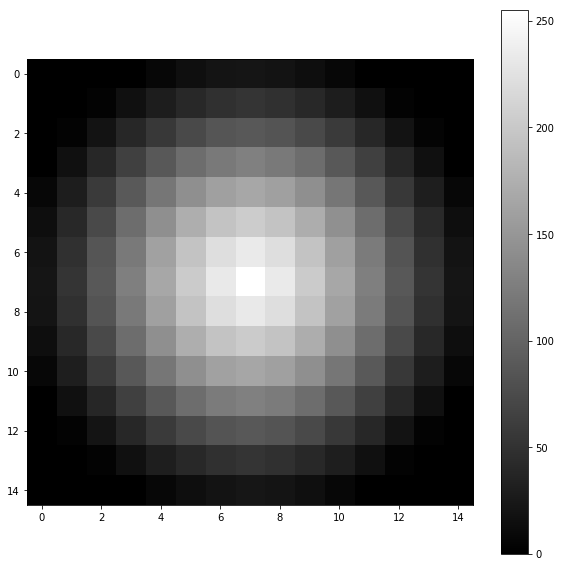

In [9]:
# And another!
sphereImg = io.imread("./Images/Sphere_15x15.png")
print(sphereImg)
plt.figure(figsize=(10,10))
plt.imshow(sphereImg, cmap='gray')
plt.colorbar() 

[[ 0  0  0 ...  0  0  0]
 [ 0  0  3 ...  3  0  0]
 [ 0  3 19 ... 19  4  0]
 ...
 [ 0  3 20 ... 19  3  0]
 [ 0  0  3 ...  3  0  0]
 [ 0  0  0 ...  0  0  0]]


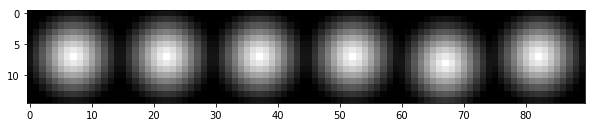

In [10]:
sphereImg = io.imread("./Images/Sphere_90x15.png")
print(sphereImg)
plt.figure(figsize=(10,10))
plt.imshow(sphereImg, cmap='gray')

(15, 90)


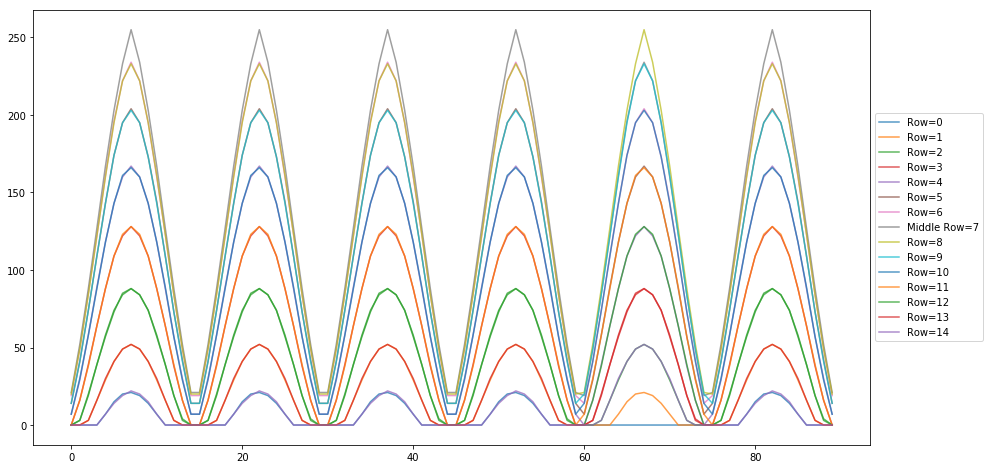

In [11]:
# Let's plot the rows of this image (remember each pixel is 0-255 representing intensity)
sphereImg = io.imread("./Images/Sphere_90x15.png")
img = sphereImg
imageHeight, imageWidth = img.shape
print(img.shape)
plt.figure(figsize=(15,8))
for row in range(0, imageHeight):
    # print(arrowNoAntiAliasing[row,])
    label = "Middle Row={}".format(row) if row == int(imageHeight / 2.0) else "Row={}".format(row)
    plt.plot(img[row,], alpha=0.75, label=label)
# plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

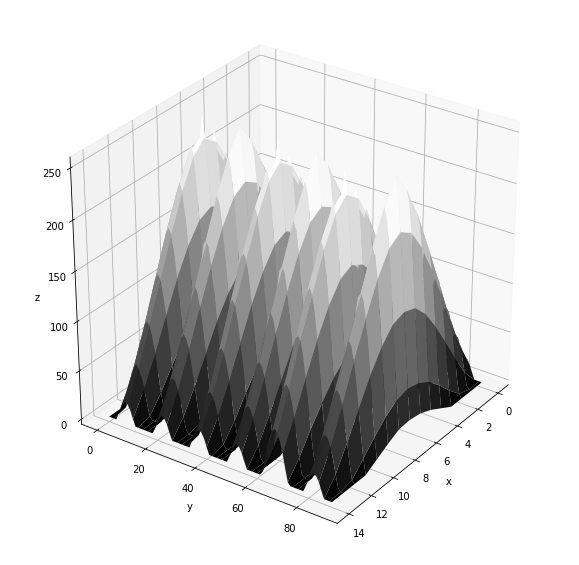

In [12]:
# sometimes, it's useful to think about these intensities in a height map format
# based on: https://stackoverflow.com/a/31806902
# and https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html#Three-dimensional-Contour-Plots
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

img = sphereImg
# create the x and y coordinate arrays (here we just use pixel indices)
xx, yy = np.mgrid[0:img.shape[0], 0:img.shape[1]]
## ax.contour3D(xx, yy, birdImageGrayscale, 50, cmap='binary')
ax.plot_surface(xx, yy, img, cmap=plt.cm.gray)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

# Sometimes the default viewing angle is not optimal
# We can use the view_init method to set the elevation and azimuthal angles. 
# Elevation is degrees above the x-y plane
# Azimuth is rotation about the z-axis
ax.view_init(elev=30, azim=35)

plt.show()

Grayscale type(birdImage):  <class 'numpy.ndarray'>
RGB type(birdImage):  <class 'numpy.ndarray'>
Grayscale (width, height):  (512, 512)
RGB (width, height):  (512, 512, 3)
Grayscale birdImage.dtype:  uint8
RGB birdImage.dtype:  uint8
RGB converted to grayscale birdImage.dtype:  float64


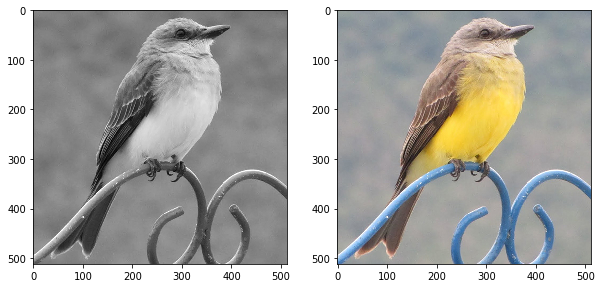

In [13]:
# This is how you read in your own images
birdImageGrayscale = io.imread("./Images/BoliviaBirdZoomed_IMG_0202_Square_BW_512x512.JPG")
birdImageRGB = io.imread("./Images/BoliviaBirdZoomed_IMG_0202_Square_512_512.jpg")
birdImageRGBAutoConvertedGrayscale = io.imread("./Images/BoliviaBirdZoomed_IMG_0202_Square_512_512.jpg", as_grey=True)

f, axes = plt.subplots(1, 2, figsize=(10, 5)) # subplots is num rows, num cols & figsize is width, height

# if you don't include cmap='gray' here it will default to viridis
# see: https://matplotlib.org/users/image_tutorial.html
imgray = axes[0].imshow(birdImageGrayscale, cmap='gray') 
# f.colorbar(imgray,ax=axes[0]) # this is how you add a colorbar to a subplot
axes[1].imshow(birdImageRGB)

# print out the image type
print("Grayscale type(birdImage): ", type(birdImageGrayscale))
print("RGB type(birdImage): ", type(birdImageRGB))

# and shape tells us the (width, height, # of channels) where # of channels = 1 for grayscale
# images and 3 for RGB images. 
print("Grayscale (width, height): ", birdImageGrayscale.shape)
print("RGB (width, height): ", birdImageRGB.shape)

# dtype is uint8 for 8-bit images (0-255). RGB 24-bit images are just 8-bit values for each channel
# Note that the auto-converted grayscale image is made up of floats [0, 1]
# So, make sure you double check and make sure you are dealing with all 8-bit [0, 255] or all floats [0,1]
# when you are running computations
print("Grayscale birdImage.dtype: ", birdImageGrayscale.dtype)
print("RGB birdImage.dtype: ", birdImageRGB.dtype)
print("RGB converted to grayscale birdImage.dtype: ", birdImageRGBAutoConvertedGrayscale.dtype)

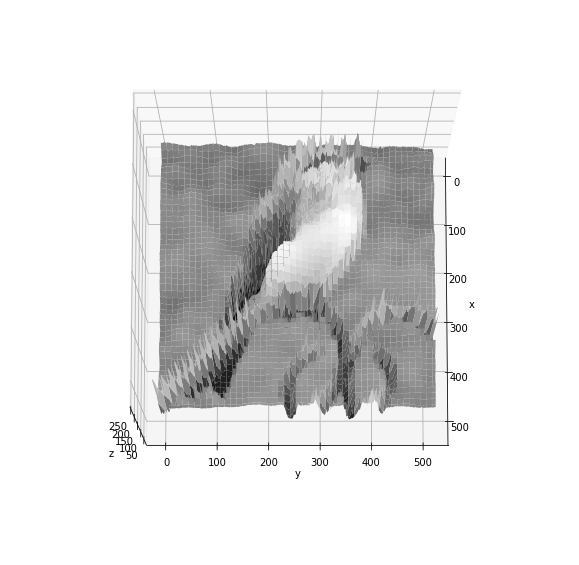

In [14]:
# uncomment this to make the plot interactive
# %matplotlib notebook 

# sometimes, it's useful to think about these intensities in a height map format
# based on: https://stackoverflow.com/a/31806902
# and https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html#Three-dimensional-Contour-Plots
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

# create the x and y coordinate arrays (here we just use pixel indices)
xx, yy = np.mgrid[0:birdImageGrayscale.shape[0], 0:birdImageGrayscale.shape[1]]
## ax.contour3D(xx, yy, birdImageGrayscale, 50, cmap='binary')
ax.plot_surface(xx, yy, birdImageGrayscale, cmap=plt.cm.gray)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

# Sometimes the default viewing angle is not optimal
# We can use the view_init method to set the elevation and azimuthal angles. 
# Elevation is degrees above the x-y plane
# Azimuth is rotation about the z-axis
ax.view_init(elev=80, azim=0)

plt.show()


Text(0.5,1,'original rgb')

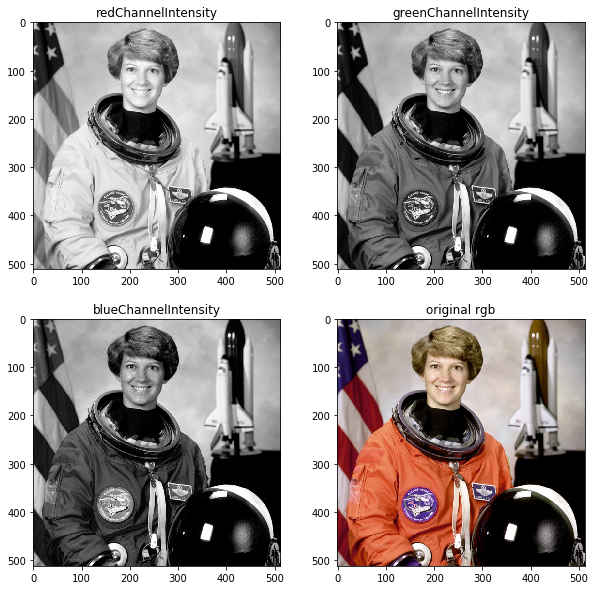

In [15]:
# Viewing the intensity of the different channels in an rgb image
f, axes = plt.subplots(2, 2, figsize=(10,10)) # subplots is num rows, num cols & figsize is width, height

# RGB images are 3D vectors with (row, col, channel)
redChannelIntensity = data.astronaut()[:,:,0]
greenChannelIntensity = data.astronaut()[:,:,1]
blueChannelIntensity = data.astronaut()[:,:,2]

# in the plots below, "lighter" means *more* of that channel in the image
# so "black" would mean none of that channel exists
axes[0, 0].imshow(redChannelIntensity, cmap='gray')
axes[0, 0].set_title("redChannelIntensity")

axes[0, 1].imshow(greenChannelIntensity, cmap='gray')
axes[0, 1].set_title("greenChannelIntensity")

axes[1, 0].imshow(blueChannelIntensity, cmap='gray')
axes[1, 0].set_title("blueChannelIntensity")

axes[1, 1].imshow(data.astronaut())
axes[1, 1].set_title("original rgb")

Text(0.5,1,'original rgb')

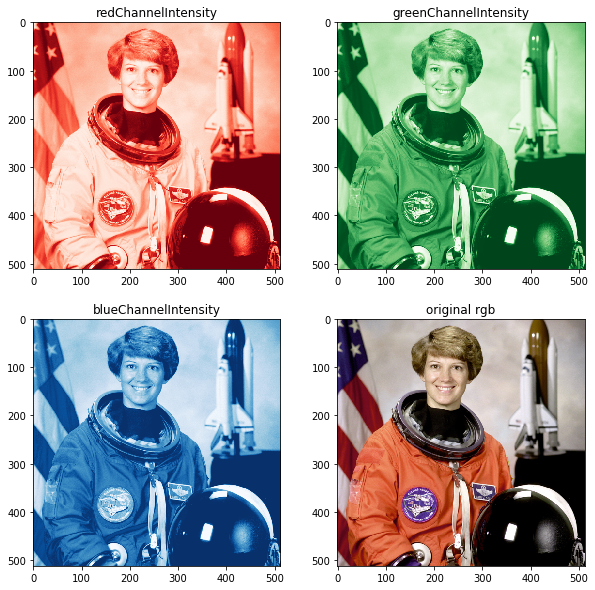

In [16]:
# We can also graph this with red, green, and blue hues (which may seem more intuitive)
f, axes = plt.subplots(2, 2, figsize=(10,10)) # subplots is num rows, num cols & figsize is width, height

# RGB images are 3D vectors with (row, col, channel)
redChannelIntensity = data.astronaut()[:,:,0]
greenChannelIntensity = data.astronaut()[:,:,1]
blueChannelIntensity = data.astronaut()[:,:,2]

# now we are graphing the intensities in their respective color
# channels but careful in your interpratation--lighter here
# again means "more" of that color in the channel
axes[0, 0].imshow(redChannelIntensity, cmap=plt.cm.Reds_r)
axes[0, 0].set_title("redChannelIntensity")

axes[0, 1].imshow(greenChannelIntensity, cmap=plt.cm.Greens_r)
axes[0, 1].set_title("greenChannelIntensity")

axes[1, 0].imshow(blueChannelIntensity, cmap=plt.cm.Blues_r)
axes[1, 0].set_title("blueChannelIntensity")

axes[1, 1].imshow(data.astronaut())
axes[1, 1].set_title("original rgb")

Text(0.5,1,'original rgb')

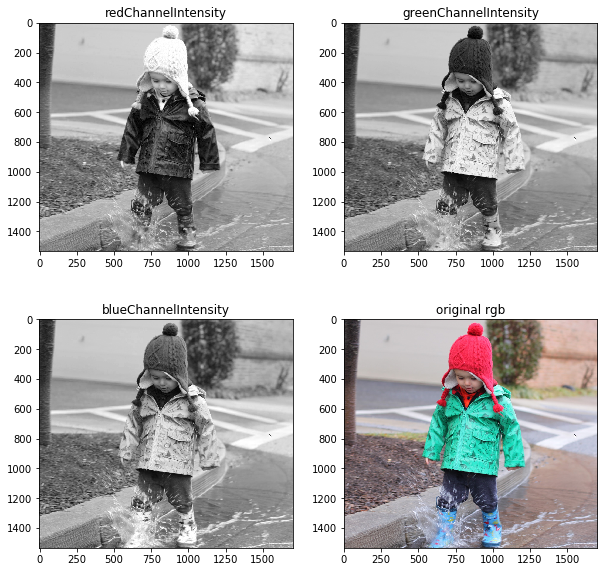

In [17]:
# Here's another example
rgbImg = io.imread("./Images/ChildHat.png")
f, axes = plt.subplots(2, 2, figsize=(10,10)) # subplots is num rows, num cols & figsize is width, height

# RGB images are 3D vectors with (row, col, channel)
redChannelIntensity = rgbImg[:,:,0]
greenChannelIntensity = rgbImg[:,:,1]
blueChannelIntensity = rgbImg[:,:,2]

# in the plots below, "lighter" means *more* of that channel in the image
# so "black" would mean none of that channel exists
axes[0, 0].imshow(redChannelIntensity, cmap='gray')
axes[0, 0].set_title("redChannelIntensity")

axes[0, 1].imshow(greenChannelIntensity, cmap='gray')
axes[0, 1].set_title("greenChannelIntensity")

axes[1, 0].imshow(blueChannelIntensity, cmap='gray')
axes[1, 0].set_title("blueChannelIntensity")

axes[1, 1].imshow(rgbImg)
axes[1, 1].set_title("original rgb")

# Some basic image processing

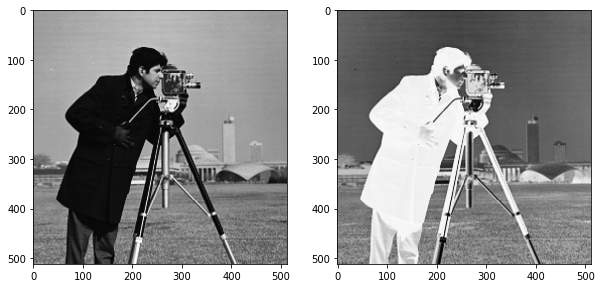

In [18]:
# Here's a simple arithmetic way to invert image
img = data.camera()
inverter = 255 if img.dtype == 'uint8' else 1.0 # necessary because grayscale can either be 0-255 or 0-1.0
invertedImg = 255 - img

f, axes = plt.subplots(1, 2, figsize=(10, 10)) # subplots is num rows, num cols & figsize is width, height

axes[0].imshow(img, cmap='gray')
axes[1].imshow(invertedImg, cmap='gray')

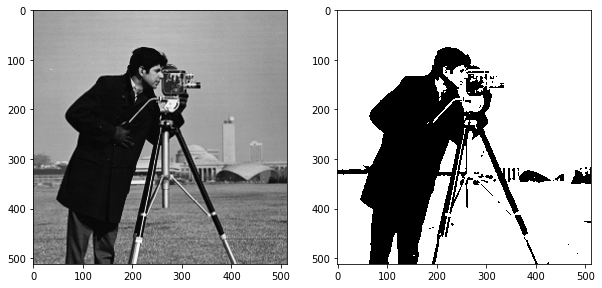

In [19]:
# Here's an (extremely) simple way to binarize an image (also called thresholding)
# See:
#  - https://www.mathworks.com/help/images/ref/imbinarize.html
#  - http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_thresholding.html
#  - https://en.wikipedia.org/wiki/Thresholding_%28image_processing%29

img = data.camera()
threshold = 0.3 # any pixel above 30% intensity converted to WHITE, all others BLACK

# check if the grayscale image is floating point (0-1.0) or uint8 (0-255)
if img.dtype == 'uint8': 
    threshold = np.uint8(threshold * 255) 
    highVal = 255
    lowVal = 0

binarizedImage = img > threshold # operation returns TRUE or FALSE (1 or 0)

f, axes = plt.subplots(1, 2, figsize=(10, 10)) # subplots is num rows, num cols & figsize is width, height

axes[0].imshow(img, cmap='gray')
axes[1].imshow(binarizedImage, cmap='gray')

87


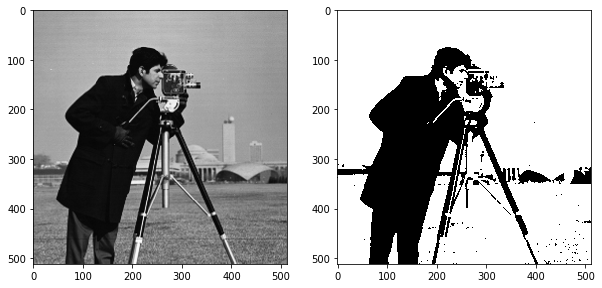

In [20]:
# And of course scikit has more sophisticated ways of coming up with thresholds
img = data.camera()
otsuThreshold = filters.threshold_otsu(img) # use Otsu's method for finding a good threshold
print(otsuThreshold)
binarizedImage = img > otsuThreshold

f, axes = plt.subplots(1, 2, figsize=(10, 10)) # subplots is num rows, num cols & figsize is width, height

axes[0].imshow(img, cmap='gray')
axes[1].imshow(binarizedImage, cmap='gray')

# Image differencing

Text(0.5,1,'thresholded diff')

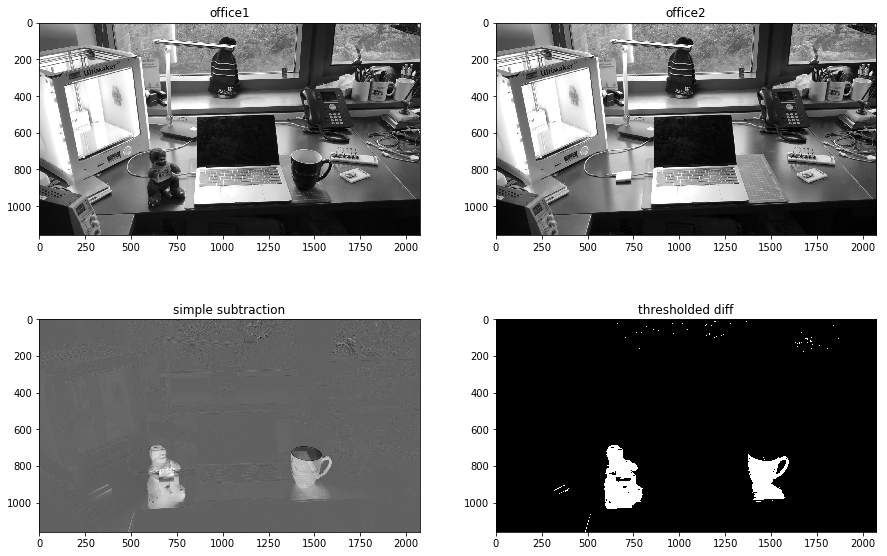

In [21]:
# How can we find what's changed between two images?
# Lots of ways to do this
# Two basic ways demonstrated below:
#  1. Simple substraction
#  2. Compare pixels between image and any pixel diff > some threshold, mark as diff

# read in the files
# as_grey converts color images to 64-bit floats. if the image is already
# grayscale then nothing happens
office1 = io.imread("./Images/Office1a.png", as_grey=True) 
office2 = io.imread("./Images/Office1c.png", as_grey=True)

# Approach 1: use basic subtraction to find differences
officeDiff = office2 - office1 # this results in some values less than 0!

# Approach 2: compare pixels between images and mark any pixel diff > some threshold
# Here, we've arbitrarily selected 0.5 (which I selected based some experimentation)
officeDiffNormalized = (officeDiff - officeDiff.min())  / (officeDiff.max() - officeDiff.min())
officeDiffThreshold = officeDiffNormalized > 0.5

# Plot the diffs!
f, axes = plt.subplots(2, 2, figsize=(15,10)) # subplots is num rows, num cols & figsize is width, height
axes[0, 0].imshow(office1, cmap='gray')
axes[0, 1].imshow(office2, cmap='gray')
axes[0, 0].set_title("office1")
axes[0, 1].set_title("office2")
axes[1, 0].imshow(officeDiff, cmap='gray')
axes[1, 1].imshow(officeDiffThreshold, cmap='gray')
axes[1, 0].set_title("simple subtraction")
axes[1, 1].set_title("thresholded diff")

# and then at this point, you can do more sophisticated things like blob detection
# (find large areas of pixels and filter out smaller areas)
# This is the basis of background/foreground segmentation and all sorts of other fun things!
# For example, once you have a mask, you could grab all underlying pixels within/around that
# mask and use that as a "template" to find the occurrence of that object in other images (or frames of a video)

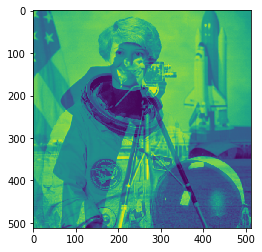

In [22]:
# Combining two images is just a matter of adding the two matrices together
# Note that I multiply by 0.5 to protect against overflow (ensure that all values remain < 255)
sumImages = 0.5 * data.astronaut()[:,:,0] + 0.5 * data.camera()
plt.imshow(sumImages)


# Smoothing filters

## Image denoising examples:
- https://people.sc.fsu.edu/~jburkardt/m_src/image_denoise/image_denoise.html
- Adding salt & pepper noise: https://stackoverflow.com/questions/22937589/how-to-add-noise-gaussian-salt-and-pepper-etc-to-image-in-python-with-opencv?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa

Smoothing with a windowSize1D= 5


NameError: name 'yZoom2' is not defined

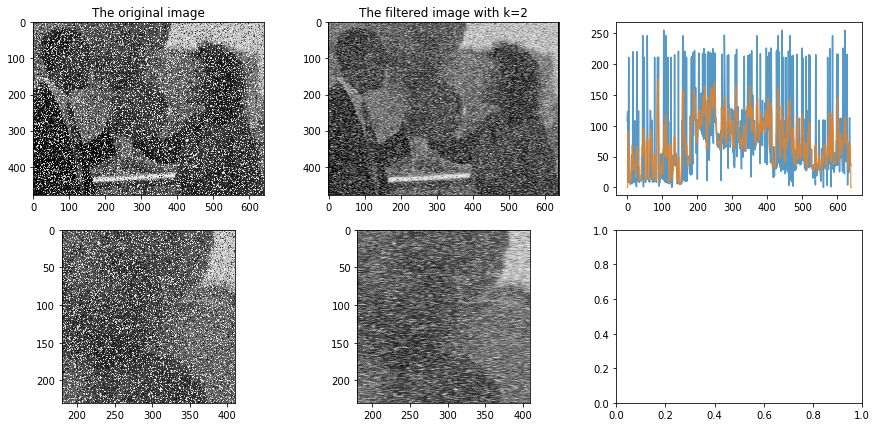

In [24]:
# ONE DIMENSIONAL IMAGE SMOOTHING ALGORITHM
# Let's build our own window-based mean filter for an image. This is very similar
# to the smoothing approaches we've previously done in the course.
# Here, we are going to manually walk through each pixel in our numpy array
# and take an average of the pixels around it (using a 1-dimensional sliding window)
# Note that manually stepping through numpy arrays is not typically done as the 
# numpy library allows you to perform full matrix operations without setting up your own 
# for loops. But we'll do it for now for educational purposes! 
# Also note that this simple example is only smoothing in the x-direction

# # img = io.imread("./Images/bears_0.05_noisy.jpg", as_grey=True) 
img = io.imread("./Images/balloons_noisy_bw.png") 

k = 2 # number of neighbors to look at, the larger k, the "blurrier" the image will get
windowSize1D = (2 * k) + 1 # the window size of our average filter
imageHeight, imageWidth = img.shape

# initialize our smoothed image to all zeros. We must specify our dtype
# here because scikit-image converted grayscale images are 64-bit floats
# vs. raw grayscale images are 8-bit ints
smoothedImage = np.full((imageHeight, imageWidth), 0, dtype=img.dtype) 

# numpy stores data in row major order
# Loop through every pixel and calculate an average for a window around that pixel
# Note that we are only smoothing here in the x-direction
print("Smoothing with a windowSize1D=", windowSize1D)
for j in range(0, imageHeight): # for each row
    for i in range(k, imageWidth - k): # and each column
        pixelsInWindow = img[j, i - k : i + k + 1] # first arg returns the row, second returns a range within that row
        avg = np.mean(pixelsInWindow)
        smoothedImage[j,i] = avg

plotFilteredImage(img, smoothedImage, k, (180,410), (230,0))

In [ ]:
# TWO DIMENSIONAL IMAGE SMOOTHING ALGORITHM
# Let's extend our one-dimensional image smoothing approach to *two* dimensions
# So now our sliding window is really a sliding box! And we can use numpy's
# fancy slicing syntax to make this really easy :)
# See: https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html

# img = io.imread("./Images/bears_0.05_noisy.jpg", as_grey=True) 
img = io.imread("./Images/balloons_noisy_bw.png")

k = 1 # number of neighbors to look at, the larger k, the "blurrier" the image will get
windowSize2D = (2 * k) + 1 # the window size of our average filter
imageHeight, imageWidth = img.shape

# initialize our smoothed image to all zeros. We must specify our dtype
# here because scikit-image converted grayscale images are 64-bit floats
# vs. raw grayscale images are 8-bit ints
smoothedImage = np.full((imageHeight, imageWidth), 0, dtype=img.dtype) 

# numpy stores data in row major order
# Loop through every pixel and calculate an average for a window around that pixel
# Note that we are only smoothing here in the x-direction
print("Smoothing with a windowSize2D=", windowSize2D)
for j in range(k, imageHeight - k): # for each row
    for i in range(k, imageWidth - k): # and each column
        pixelsInWindow = img[j - k : j + k + 1, i - k : i + k + 1] # get the matrix within our sliding window
        avg = np.mean(pixelsInWindow)
        smoothedImage[j,i] = avg

plotFilteredImage(img, smoothedImage, k, (180,410), (230,0))

In [ ]:
# Now, let's do this the *right* way--using a kernel and convolution! :)
# Some example kernels: https://en.wikipedia.org/wiki/Kernel_(image_processing)
img = birdImageGrayscale # feel free to change this

# 3x3 mean "box" filter
meanBoxFilter3x3 = np.array([[1/9, 1/9, 1/9],
                          [1/9, 1/9, 1/9],
                          [1/9, 1/9, 1/9],])

# We use scipy's signal library (just like we did in earlier parts of the course) but
# this time it's a 2D convolution rather than a 1D
meanBoxFilter3x3Result = signal.convolve2d(img, meanBoxFilter3x3, boundary='symm', mode='same')
k = int((meanBoxFilter3x3Result.shape[0] - 1)/2.0)
plotFilteredImage(img, meanBoxFilter3x3Result, k, (180,410), (230,0))


In [ ]:
# Simple check between our own algorithm and convolution :)
k = 5
img = birdImageGrayscale
imageHeight, imageWidth = img.shape
manualSmoothedImage = np.full((imageHeight, imageWidth), 0, dtype=img.dtype)
slidingWindowDimension = (2 * k + 1) 
numCellsInSlidingWindow = slidingWindowDimension ** 2 # numCells = (2k+1)^2
meanBoxFilter = np.full((slidingWindowDimension, slidingWindowDimension), 1 / numCellsInSlidingWindow)

# First manually smooth the image using a 2D sliding window
print("Smoothing with k={}, boxFilter.width={}, boxFilter.numCells={}".format(k, meanBoxFilter.shape[1], numCellsInSlidingWindow))
for j in range(k, imageHeight - k): # for each row
    for i in range(k, imageWidth - k): # and each column
        pixelsInWindow = img[j - k : j + k + 1, i - k : i + k + 1] # get the matrix within our sliding window
        avg = np.mean(pixelsInWindow)
        manualSmoothedImage[j,i] = avg

convolutionSmoothedImage = signal.convolve2d(img, meanBoxFilter, boundary='symm', mode='same')
print(manualSmoothedImage.shape)
print(convolutionSmoothedImage.shape)
# diffImage = manualSmoothedImage - convolutionSmoothedImage

# The titles of the plotted images are wrong (because we are not displaying raw and filtered but instead two filtered)
# Still, this let's us compare and verify that our manual alg works :)
# Because imshow auto-normalizes the images when it displays them, we have to turn this off
# the convolution image is going to look a bit darker (because the manually smoothed image has a border of intensity 0)
plotFilteredImage(manualSmoothedImage, convolutionSmoothedImage, k, (180,410), (230,0))


In [ ]:
# Make a larger mean box filter (make k bigger)
# np.full iniitalizes an array with a given shape and fill value
# img = birdImageGrayscale
k = 3
slidingWindowDimension = (2 * k + 1)
numCellsInSlidingWindow = slidingWindowDimension ** 2 # numCells = (2k+1)^2
meanBoxFilter = np.full((slidingWindowDimension, slidingWindowDimension), 1 / numCellsInSlidingWindow)

img = io.imread("./Images/balloons_noisy_bw.png") 
meanBoxFilterResult = signal.convolve2d(img, meanBoxFilter, boundary='symm', mode='same')
plotFilteredImage(img, meanBoxFilterResult, k, (180,410), (230,0),)

In [ ]:
# Playing with a gaussian filter. First, we will do it manually (this cell) and then use scikit gaussian filter (next cell)
# http://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.gaussian

# manual guassian kernels
guassianKernel21x21WithSigma1 = create_gaussian_kernel(21, 1)
guassianKernel21x21WithSigma3 = create_gaussian_kernel(21, 3)
guassianKernel21x21WithSigma5 = create_gaussian_kernel(21, 5)

gaussianFilter21x21Sigma1Result = signal.convolve2d(birdImageGrayscale, guassianKernel21x21WithSigma1, boundary='symm', mode='same')
gaussianFilter21x21Sigma3Result = signal.convolve2d(birdImageGrayscale, guassianKernel21x21WithSigma3, boundary='symm', mode='same')
gaussianFilter21x21Sigma5Result = signal.convolve2d(birdImageGrayscale, guassianKernel21x21WithSigma5, boundary='symm', mode='same')

f, axes = plt.subplots(2, 4, figsize=(20, 10)) # subplots is num rows, num cols & figsize is width, height

# axes is row, col
axes[0, 0].imshow(birdImageGrayscale)
axes[0, 0].set_title("The original image")

axes[1, 0].imshow(birdImageGrayscale)
axes[1, 0].set_xlim(180, 410) # zoom in!
axes[1, 0].set_ylim(230, 0)   # zoom in!

axes[0, 1].imshow(gaussianFilter21x21Sigma1Result)
axes[0, 1].set_title("Gaussian filtered with sigma=1")

axes[1, 1].imshow(gaussianFilter21x21Sigma1Result)
axes[1, 1].set_xlim(180, 410)
axes[1, 1].set_ylim(230, 0)

axes[0, 2].imshow(gaussianFilter21x21Sigma3Result)
axes[0, 2].set_title("Gaussian filtered with sigma=3")

axes[1, 2].imshow(gaussianFilter21x21Sigma3Result)
axes[1, 2].set_xlim(180, 410)
axes[1, 2].set_ylim(230, 0)

axes[0, 3].imshow(gaussianFilter21x21Sigma5Result)
axes[0, 3].set_title("Gaussian filtered with sigma=5")

axes[1, 3].imshow(gaussianFilter21x21Sigma5Result)
axes[1, 3].set_xlim(180, 410)
axes[1, 3].set_ylim(230, 0)

In [ ]:
# now do it automagically with the built in guassian filter
# note that the built-in gaussian filter does not allow us to specify both sigma and the kernel size... this is because 
# the kernel size is calculated automatically as: kernel_size = 2*int(truncate*sigma + 0.5) + 1
# The truncate var defaults to 4.0. See: http://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.gaussian
# So, with a sigma of 1, we would have kernel_size = 2 * int(4 * 1 + 0.5) + 1 = 2*4+1 = 9
# Sigma : Truncate : Kernel Size
#    1  :   4      : 9
#    2  :   4      : 17
#    3  :   4      : 25

gaussianResultSigma1 = skimage.filters.gaussian(birdImageGrayscale,sigma=1)
gaussianResultSigma3 = skimage.filters.gaussian(birdImageGrayscale,sigma=3)
gaussianResultSigma5 = skimage.filters.gaussian(birdImageGrayscale,sigma=5)

f, axes = plt.subplots(2, 4, figsize=(20, 10)) # subplots is num rows, num cols & figsize is width, height

# axes is row, col
axes[0, 0].imshow(birdImageGrayscale)
axes[0, 0].set_title("The original image")

axes[1, 0].imshow(birdImageGrayscale)
axes[1, 0].set_xlim(180, 410) # zoom in!
axes[1, 0].set_ylim(230, 0)   # zoom in!

axes[0, 1].imshow(gaussianResultSigma1)
axes[0, 1].set_title("Gaussian filtered with sigma=1")

axes[1, 1].imshow(gaussianResultSigma1)
axes[1, 1].set_xlim(180, 410)
axes[1, 1].set_ylim(230, 0)

axes[0, 2].imshow(gaussianResultSigma3)
axes[0, 2].set_title("Gaussian filtered with sigma=3")

axes[1, 2].imshow(gaussianResultSigma3)
axes[1, 2].set_xlim(180, 410)
axes[1, 2].set_ylim(230, 0)

axes[0, 3].imshow(gaussianResultSigma5)
axes[0, 3].set_title("Gaussian filtered with sigma=5")

axes[1, 3].imshow(gaussianResultSigma5)
axes[1, 3].set_xlim(180, 410)
axes[1, 3].set_ylim(230, 0)

In [ ]:
# Let's play with some linear filters!

kernelSize = 3
f, axes = plt.subplots(2, 4, figsize=(20, 10)) # subplots is num rows, num cols & figsize is width, height

# Setup the identity kernel and graph
identityKernel = np.full((kernelSize, kernelSize), 0)
identityKernel[1,1] = 1
identityKernelResult = signal.convolve2d(birdImageGrayscale, identityKernel, boundary='symm', mode='same')

axes[0, 0].imshow(identityKernel, cmap='gray')
axes[0, 0].set_title("identityKernel")

axes[1, 0].imshow(identityKernelResult)
axes[1, 0].set_title("identityKernelResult")

# Shift kernel to left
shiftLeftKernel = np.full((kernelSize, kernelSize), 0)
shiftLeftKernel[1,0] = 1
shiftLeftKernelResult = signal.convolve2d(birdImageGrayscale, shiftLeftKernel, boundary='fill', fillvalue=255)

# axes[0, 1].imshow(shiftLeftKernel, cmap='gray', norm=NoNorm()) # by default imshow calcs min/max of vals and distorts display
axes[0, 1].imshow(shiftLeftKernel, cmap='gray')
axes[0, 1].set_title("shiftLeftKernel")

axes[1, 1].imshow(shiftLeftKernelResult)
axes[1, 1].set_title("shiftLeftKernelResult")
axes[1, 1].set_xlim(500, 515) # zoom in to show that we shifted image one pixel to left


# Average filter kernel
meanSmoothingKernel = np.full((kernelSize, kernelSize), 1/(kernelSize * kernelSize))
meanSmoothingKernelResult = signal.convolve2d(birdImageGrayscale, meanSmoothingKernel, boundary='symm', mode='same')

axes[0, 2].imshow(meanSmoothingKernel)
axes[0, 2].set_title("meanSmoothingKernel")

axes[1, 2].imshow(meanSmoothingKernelResult)
axes[1, 2].set_title("meanSmoothingKernelResult")

# and because we are deal with linear filters we can combine them in interesting ways
# here's a basic sharpening filter
# See: https://classroom.udacity.com/courses/ud955/lessons/3166558835/concepts/31802886980923
sharpeningKernel = identityKernel * 2 - meanSmoothingKernel
print("sharpeningKernel:", sharpeningKernel)
sharpeningKernelResult = signal.convolve2d(birdImageGrayscale, sharpeningKernel, boundary='symm', mode='same')

axes[0, 3].imshow(sharpeningKernel)
axes[0, 3].set_title("sharpeningKernel")

axes[1, 3].imshow(sharpeningKernelResult)
axes[1, 3].set_title("sharpeningKernelResult")



In [ ]:
# more playing with linear filters
# this time, let's use an edge detection kernel
# from: https://en.wikipedia.org/wiki/Kernel_(image_processing)
img = birdImageGrayscale
edgeDetectionKernel = np.array([[-1, -1, -1],
                                [-1, 8, -1],
                                [-1, -1, -1]])

edgeDetectionKernelResult = signal.convolve2d(img, edgeDetectionKernel, boundary='symm', mode='same')
plotFilteredImage(img, edgeDetectionKernelResult, 1, (180,410), (230,0),)

In [ ]:
# a median filter is not a linear filter but it's particularly good at denoising
# images (especially salt-and-pepper noise that can occur from a dirty lens, etc.)
from skimage.filters.rank import median

img = io.imread("./Images/balloons_noisy_bw.png") 

k = 2
windowSize = 2 * k + 1

# selem is specifies the kernel neighborhood expressed as a 2D array of 1's and 0's
# if no selem is specified, a full square of size 3 is used
# see: http://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.median
medianFilterImg = median(img, selem=disk(windowSize))
plotFilteredImage(img, medianFilterImg, k, (270,570), (300,0),)

# Edge Detection

In [ ]:
# Let's try to create our own edge detection algorithm
# Again, we will manually walk through the numpy image array and
# then see later how to do it using the full force of the scikit-image libraries
# this program assumes a raw grayscale image!

edgeCaseStudyImage1 = io.imread("./Images/EdgeDetectionCaseStudy_NoAntiAliasing_1024w.png")
arrowAntiAliased = io.imread("./Images/Arrow_16x16_AntiAliased.png")
img = arrowAntiAliased
threshold = 128 # the minimum difference between two neighboring pixels in order to be defined as an edge
k = 1 # number of neighbors to look at in each direction

# loop through all pixels and check neighbors for diff > threshold
imageHeight, imageWidth = img.shape
edgeImage = np.full((imageHeight, imageWidth), 0) # start out all black

# numpy stores data in row major order
# Loop through every pixel and check for a difference
for j in range(1, imageHeight):
    for i in range(1, imageWidth):
        for v in range(j - k, j + k):
            for u in range(i - k, i + k):
                if(abs(int(img[i, j]) - img[u,v]) > threshold):
                    edgeImage[i, j] = 255
                    
print(edgeImage)
plt.imshow(edgeImage, cmap='gray')
        
        

In [ ]:
# Playing around with Canny edge detection
# See: http://scikit-image.org/docs/dev/auto_examples/edges/plot_canny.html

exteriorDoorGrayscale = io.imread("./Images/IMG_1269_512h.jpg", as_grey=True)
hallwayGrayscale = io.imread("./Images/IMG_0087_512h.jpg", as_grey=True)
leavesGrayscale = io.imread("./Images/IMG_2135_512h.jpg", as_grey=True)

# TODO: In future, change this example to not have anti-aliased shapes
edgeDetectionCaseStudyImage = io.imread("./Images/EdgeDetectionCaseStudy_Square_512x512.png", as_grey=True) 

f, axes = plt.subplots(3, 4, figsize=(30, 15)) # subplots is num rows, num cols & figsize is width, height

# Edge detection examples
birdCannySigma1 = feature.canny(birdImageGrayscale)
birdCannySigma3 = feature.canny(birdImageGrayscale, sigma=3)

row, col = 0, 0
axes[row, col].imshow(birdImageGrayscale, cmap='gray')
axes[row, col].set_title("Original")
row += 1

axes[row, col].imshow(birdCannySigma1, cmap='gray')
axes[row, col].set_title("birdCannySigma1")
row += 1

axes[row, col].imshow(birdCannySigma3, cmap='gray')
axes[row, col].set_title("birdCannySigma3")
row += 1

# edge case study
edgeCaseStudyCannySigma1 = feature.canny(edgeDetectionCaseStudyImage)
edgeCaseStudyCannySigma3 = feature.canny(edgeDetectionCaseStudyImage, sigma=3)

row, col = 0, 1
axes[row, col].imshow(edgeDetectionCaseStudyImage, cmap='gray')
axes[row, col].set_title("Original")
row += 1

axes[row, col].imshow(edgeCaseStudyCannySigma1, cmap='gray')
axes[row, col].set_title("edgeCaseStudyCannySigma1")
row += 1

axes[row, col].imshow(edgeCaseStudyCannySigma3, cmap='gray')
axes[row, col].set_title("edgeCaseStudyCannySigma3")

# hallway
hallwayCannySigma1 = feature.canny(hallwayGrayscale)
hallwayCannySigma3 = feature.canny(hallwayGrayscale, sigma=3)

row, col = 0, 2
axes[row, col].imshow(hallwayGrayscale, cmap='gray')
axes[row, col].set_title("Original")
row += 1

axes[row, col].imshow(hallwayCannySigma1, cmap='gray')
axes[row, col].set_title("hallwayCannySigma1")
row += 1

axes[row, col].imshow(hallwayCannySigma3, cmap='gray')
axes[row, col].set_title("hallwayCannySigma3")

# leaves
leavesCannySigma1 = feature.canny(leavesGrayscale)
leavesCannySigma3 = feature.canny(leavesGrayscale, sigma=3)

row, col = 0, 3
axes[row, col].imshow(leavesGrayscale, cmap='gray')
axes[row, col].set_title("Original")
row += 1

axes[row, col].imshow(leavesCannySigma1, cmap='gray')
axes[row, col].set_title("leavesCannySigma1")
row += 1

axes[row, col].imshow(leavesCannySigma3, cmap='gray')
axes[row, col].set_title("leavesCannySigma3")

plt.tight_layout()

# exterior door
# doorCannySigma1 = feature.canny(exteriorDoorGrayscale)
# doorCannySigma3 = feature.canny(exteriorDoorGrayscale, sigma=3)

# row, col = 0, 1
# axes[row, col].imshow(exteriorDoorGrayscale, cmap='gray')
# axes[row, col].set_title("Original")
# row += 1

# axes[row, col].imshow(doorCannySigma1, cmap='gray')
# axes[row, col].set_title("doorCannySigma1")
# row += 1

# axes[row, col].imshow(doorCannySigma3, cmap='gray')
# axes[row, col].set_title("doorCannySigma3")

In [ ]:
# Feature detection : corners
# See: 
#  - http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_corner.html
#  - http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_brief.html
from skimage.feature import (match_descriptors, corner_peaks, corner_harris,
                             plot_matches, BRIEF)

img = birdImageGrayscale
coords = corner_peaks(corner_harris(img), min_distance=5)
f, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img, cmap=plt.cm.gray)
axes[1].imshow(img, interpolation='nearest', cmap=plt.cm.gray)
axes[1].plot(coords[:, 1], coords[:, 0], '+r', markersize=15)

In [ ]:
# Blob detection (Incomplete)
# See: http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_blob.html#sphx-glr-auto-examples-features-detection-plot-blob-py
from skimage.feature import blob_log
from math import sqrt

img = birdImageGrayscale
blobs = blob_log(img, max_sigma=30, num_sigma=10, threshold=.1)
print(blobs)

# Some interesting links to explore
- An interactive Jupyter Notebook for image convolution: https://tonysyu.github.io/ipython-jupyter-widgets-an-image-convolution-demo.html#.WvyS8jIvxJ4
- Jake VanderPlas's face detection pipeline using HOG and an SVM: https://jakevdp.github.io/PythonDataScienceHandbook/05.14-image-features.html
- Using Region Adjacency Graphs (RAGs): https://vcansimplify.wordpress.com/2014/07/06/scikit-image-rag-introduction/

# Sandbox

In [ ]:
a = np.array([[1,2,3,4], [5,6,7,8]])
print("shape: ", a.shape)
print(a)

In [ ]:
arrowNoAntiAliasing = io.imread("./Images/Arrow_16x16_NoAntiAliasing.png", as_grey=True)
print(arrowNoAntiAliasing)

arrowAntiAliased = io.imread("./Images/Arrow_16x16_AntiAliased.png", as_grey=True)
print(arrowAntiAliased)

In [ ]:
a = np.array([[1,2,3,4], [5,6,7,8], [9,10,11,12]])
a[1,2:4] # retrieves row 1, and columns 2 through 4

In [ ]:
np.full((3, 2), np.inf)

In [ ]:
from skimage.morphology import disk
print(disk(5))

In [ ]:
a = np.array([[2,2,2], [2,3,2], [2,2,2]])
print(a)